<a href="https://colab.research.google.com/github/dkisselev-zz/llm_engineering/blob/wk6-exerc/week6/community-contributions/dkisselev-zz/Week6-Excerise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Product Pricer Challenge

A baseline established by gpt4o and attempt to beat it


## Initialize and load configuration

In [2]:
# imports

import os
import re
import math
import json
import random
import pickle

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

from huggingface_hub import login
from openai import OpenAI

from items import Item
from testing import Tester

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

In [4]:
# environment

try:
  from google.colab import userdata
  os.environ['OPENAI_API_KEY']=userdata.get('OPENAI_API_KEY')
  os.environ['HF_TOKEN']=userdata.get('HF_TOKEN')
  print("✅ Using Colab secrets")
except:
  from dotenv import load_dotenv
  load_dotenv(override=True)
  os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
  os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')
  print("✅ Using local .env file")

✅ Using Colab secrets


In [5]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [6]:
openai = OpenAI()

In [7]:
%matplotlib inline

In [8]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train2.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test2.pkl', 'rb') as file:
    test = pickle.load(file)

with open('validation2.pkl','rb') as file:
    validation = pickle.load(file)

In [9]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, I'm suggesting we go with 500 examples (and 1 epoch)

fine_tune_train = train[:500]
fine_tune_validation = train[500:550]

In [42]:
# Weight and Biases
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer-ft"}}

## Helpers

In [103]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [99]:
# Prompt
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [100]:
def messages_with_price(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

## Baseline *gpt4o*

**Error:** $78.02 RMSLE 0.81 Hits 55.6%

In [14]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06",
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $280.00 Truth: $374.41 Error: $94.41 SLE: 0.08 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $50.00 Truth: $225.11 Error: $175.11 SLE: 2.22 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $30.47 Truth: $61.68 Error: $31.21 SLE: 0.47 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $400.00 Truth: $599.99 Error: $199.99 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $23.99 Truth: $16.99 Error: $7.00 SLE: 0.11 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.00 Truth: $31.99 Error: $16.99 SLE: 0.52 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $110.47 Truth: $101.79 Error: $8.68 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $329.00 Truth: $289.00 Error: $40.00 SLE: 0.02 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $500.00 Truth: $635.86 Error: $135.86 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $47.99 Truth: $65.99 Error: $18.00 SLE: 0.10 It

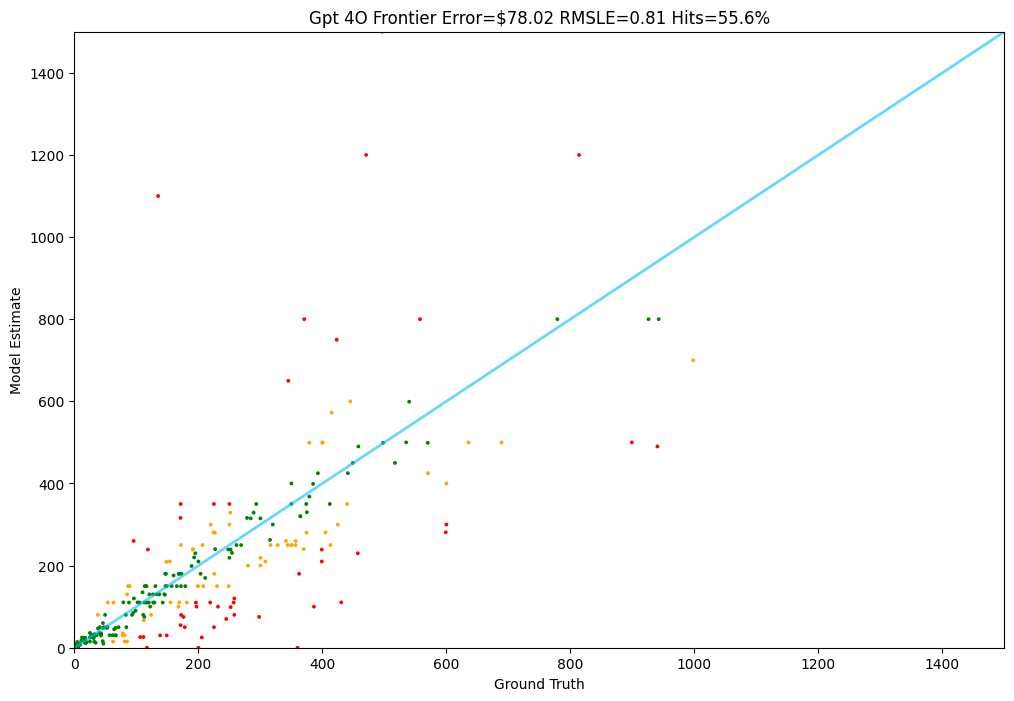

In [19]:
Tester.test(gpt_4o_frontier, test)

## Fine tuned baseline *gpt4o*

**Error:** $105.37 RMSLE 0.84 Hits 41.2%

### Data Preprocessing

Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [101]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...

def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_with_price(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [22]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [23]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [25]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [26]:
train_file

FileObject(id='file-LYev7WjfBjHN2RdRSHosQx', bytes=470371, created_at=1761276256, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [27]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [28]:
validation_file

FileObject(id='file-E7F4CkdzSHMM6qJayUPmD1', bytes=47059, created_at=1761276256, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

### Fine Tune the model

In [116]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

KeyboardInterrupt: 

In [62]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-OzTj9dzJRYqy4YCsMPy0OFFu', created_at=1761276266, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:personal:pricer:CU2zCnFT', finished_at=1761277353, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-pJCQ5ENOWAeUeCm6e5uj62MI', result_files=['file-9RjUHQ5wpFo3FZ16FDEjz5'], seed=42, status='succeeded', trained_tokens=98018, training_file='file-LYev7WjfBjHN2RdRSHosQx', validation_file='file-E7F4CkdzSHMM6qJayUPmD1', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-OzTj9dzJRYqy4YCsMPy0OFFu'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyper

In [63]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [64]:
job_id

'ftjob-OzTj9dzJRYqy4YCsMPy0OFFu'

In [65]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-OzTj9dzJRYqy4YCsMPy0OFFu', created_at=1761276266, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:personal:pricer:CU2zCnFT', finished_at=1761277353, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=1.8, n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-pJCQ5ENOWAeUeCm6e5uj62MI', result_files=['file-9RjUHQ5wpFo3FZ16FDEjz5'], seed=42, status='succeeded', trained_tokens=98018, training_file='file-LYev7WjfBjHN2RdRSHosQx', validation_file='file-E7F4CkdzSHMM6qJayUPmD1', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-OzTj9dzJRYqy4YCsMPy0OFFu'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size=1, learning_ra

In [66]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-EXZnHc0eQa85dvedQMok77Gx', created_at=1761278191, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-v9yX2wn2TmR44JSZXRtywHKH', created_at=1761278185, level='info', message='Usage policy evaluations completed, model is now enabled for sampling', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-mmrGYs4BFYjYGZn1kh92Xh2h', created_at=1761278185, level='info', message='Moderation checks for snapshot ft:gpt-4o-mini-2024-07-18:personal:pricer:CU2zCnFT passed.', object='fine_tuning.job.event', data={'blocked': False, 'results': [{'flagged': False, 'category': 'harassment/threatening', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'sexual', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'sexual/minors', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'propaganda', 'enforcement': 'blocking'

### Run inference on the fine tune model

In [67]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [136]:
# Try this out

messages_for(test[237])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nFleck 2510 Timer Mechanical Filter Control Head\n- Mechanical 2510 control head for filter systems - - 12-day timer initiated backwash - - Maximum 17 GPM backwash (includes 7 GPM DLFC) - - Standard 2. 5 -8 NPSM mounting base - - Requires yoke or bypass to connect to plumbing -Heavy duty 2510 electromechanical control valve provides simple and durable backwash control for most common backwashing filters. A maximum of 17 GPM available backwash can handle even dense iron filter medias. Dedicated piston motor provides powerful piston movement that reduces system maintenance. New Fleck 2510 filter valve replacement for filter tanks Fully adjustable cycles for backwash and rinse times For back-washing filters, allows for strong'},
 {'role': 'assistant', 'content': 'Price is $'}]

In [70]:
# The function for gpt-4o fine tuned

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name,
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [77]:
print(test[237].price)
print(gpt_fine_tuned(test[237]))

425.0
164.5


1: Guess: $490.77 Truth: $374.41 Error: $116.36 SLE: 0.07 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $76.47 Truth: $225.11 Error: $148.64 SLE: 1.15 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $65.65 Truth: $61.68 Error: $3.97 SLE: 0.00 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $277.65 Truth: $599.99 Error: $322.34 SLE: 0.59 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $14.98 Truth: $16.99 Error: $2.01 SLE: 0.01 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $13.66 Truth: $31.99 Error: $18.33 SLE: 0.66 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $139.98 Truth: $101.79 Error: $38.19 SLE: 0.10 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $262.47 Truth: $289.00 Error: $26.53 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $349.99 Truth: $635.86 Error: $285.87 SLE: 0.35 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $69.99 Truth: $65.99 Error: $4.00 SLE: 0.00 It

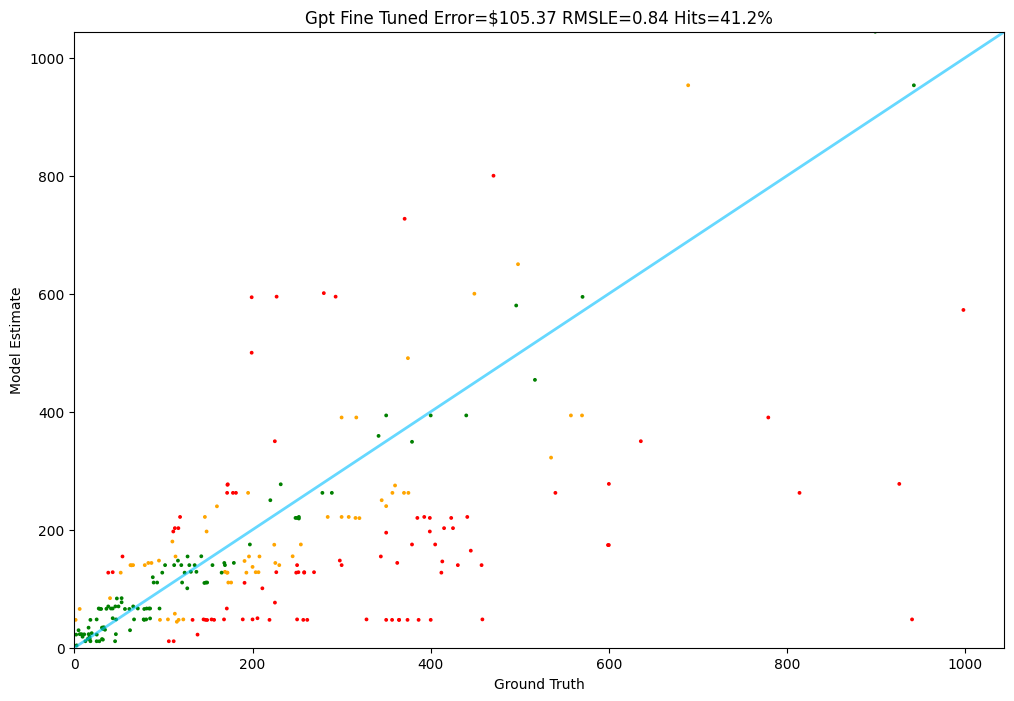

In [102]:
Tester.test(gpt_fine_tuned, test)

## gpt 4.1 base
**Error:** $70.36 RMSLE=0.522 Hits=64.4%

In [171]:
def gpt_4_1_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4.1-2025-04-14",
        messages=messages_for(item),
        seed=42,
        max_completion_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $295.00 Truth: $374.41 Error: $79.41 SLE: 0.06 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $74.00 Truth: $225.11 Error: $151.11 SLE: 1.22 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $47.99 Truth: $61.68 Error: $13.69 SLE: 0.06 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $399.00 Truth: $599.99 Error: $200.99 SLE: 0.17 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $14.99 Truth: $16.99 Error: $2.00 SLE: 0.01 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $69.99 Truth: $101.79 Error: $31.80 SLE: 0.14 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $269.00 Truth: $289.00 Error: $20.00 SLE: 0.01 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $300.00 Truth: $635.86 Error: $335.86 SLE: 0.56 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $39.99 Truth: $65.99 Error: $26.00 SLE: 0.24 It

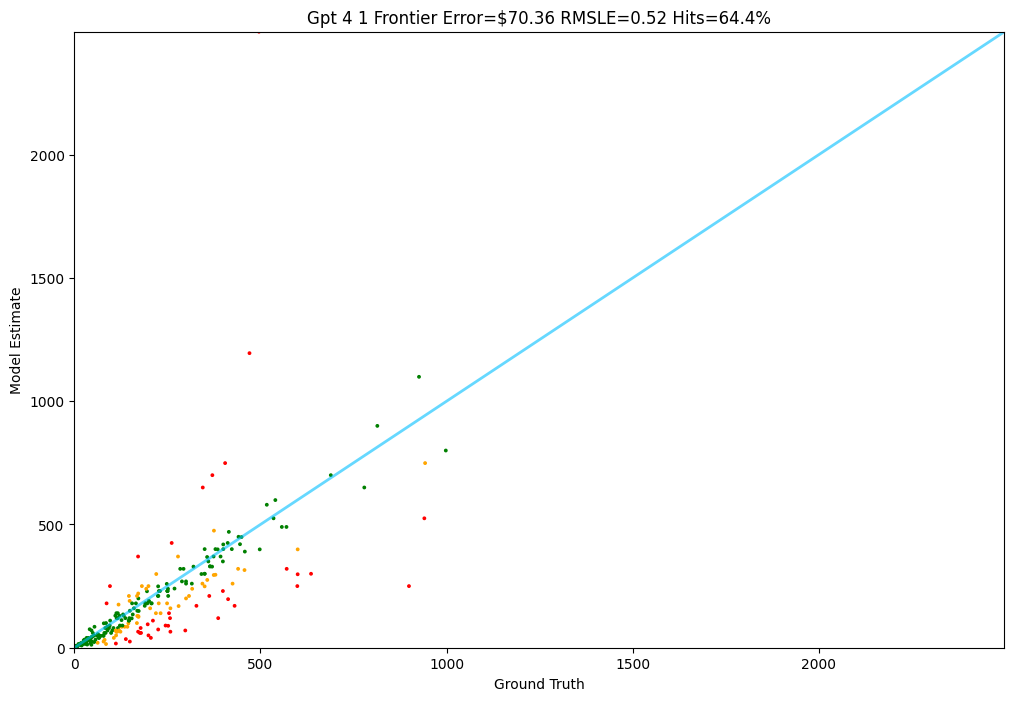

In [172]:
Tester.test(gpt_4_1_frontier, test)

### gpt 4.1 hypertuned , extended dataset
**Error**: $67.93, RMSLE=0.47, Hits 68.8

In [209]:
def gpt_4_1_hypertuned(item):
    response = openai.chat.completions.create(
        model="gpt-4.1-2025-04-14",
        messages=messages_v2(item, with_price=False),
        seed=42,
        temperature=0.2,
        max_completion_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $319.99 Truth: $374.41 Error: $54.42 SLE: 0.02 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $109.99 Truth: $225.11 Error: $115.12 SLE: 0.51 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $61.99 Truth: $61.68 Error: $0.31 SLE: 0.00 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $599.99 Truth: $599.99 Error: $0.00 SLE: 0.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $16.99 Truth: $16.99 Error: $0.00 SLE: 0.00 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $16.99 Truth: $31.99 Error: $15.00 SLE: 0.37 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $69.99 Truth: $101.79 Error: $31.80 SLE: 0.14 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $289.00 Truth: $289.00 Error: $0.00 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $499.99 Truth: $635.86 Error: $135.87 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $49.99 Truth: $65.99 Error: $16.00 SLE: 0.07 Item:

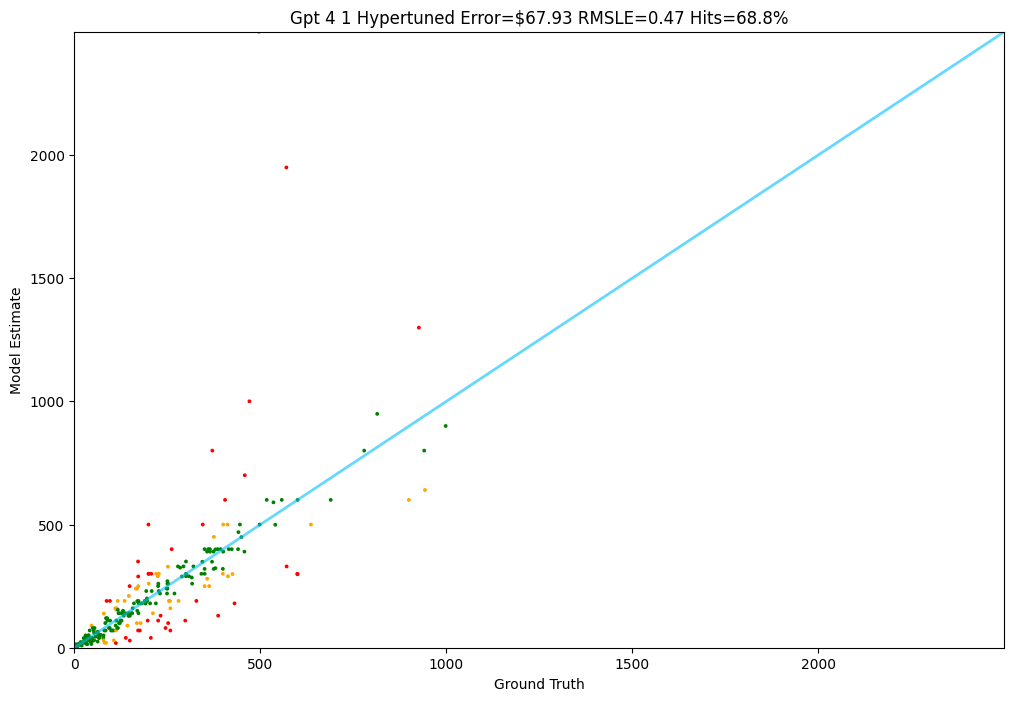

In [210]:
Tester.test(gpt_4_1_hypertuned, test)

## gpt-5 base
**Error:** $77.97 RMLSE=0.53 Hits=61.6% (reasoning_effort="minimal"

**Error:** $70.63 RMLSE=0.51 Hits=61.6% (reasoning_effort="low"

In [114]:
def gpt_5_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-5-2025-08-07",
        messages=messages_for(item),
        seed=42,
        reasoning_effort="low",
        max_completion_tokens=800
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $349.00 Truth: $374.41 Error: $25.41 SLE: 0.00 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $94.99 Truth: $225.11 Error: $130.12 SLE: 0.73 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $49.99 Truth: $61.68 Error: $11.69 SLE: 0.04 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $379.00 Truth: $599.99 Error: $220.99 SLE: 0.21 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $12.99 Truth: $16.99 Error: $4.00 SLE: 0.06 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $19.99 Truth: $31.99 Error: $12.00 SLE: 0.20 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $119.99 Truth: $101.79 Error: $18.20 SLE: 0.03 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $299.99 Truth: $289.00 Error: $10.99 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $299.00 Truth: $635.86 Error: $336.86 SLE: 0.57 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $49.99 Truth: $65.99 Error: $16.00 SLE: 0.07 I

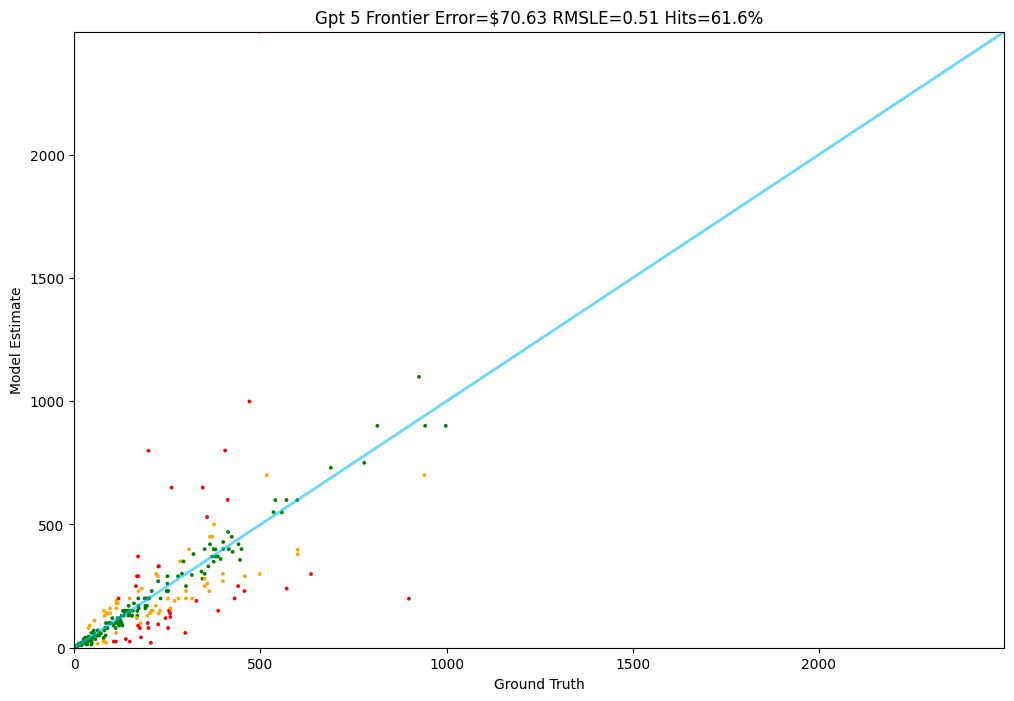

In [115]:
Tester.test(gpt_5_frontier, test)

## gpt 4.1 fine-tuned with extended dataset

### Data Preprocessing

In [174]:

def messages_v2(item, with_price=True):
    system_message = \
        "Role: You are a retail price estimator.\n" \
        "Market: United States; Currency: USD.\n" \
        "Scope: Predict the most likely new retail price. Ignore taxes, shipping, coupons, bundles, used/renewed.\n" \
        "Output: Only a number with two decimals (e.g., 129.99). No $ sign. No words.\n" \
        "Think silently; do not reveal reasoning."

    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": str({
            "query":"price_estimate",
            "locale":"en_US",
            "currency":"USD",
            "category":item.category,
            "description":user_prompt,
            "brand":json.loads(item.details).get("Brand","Unknown")
            })
        },
        {"role": "assistant", "content": f"Price is ${item.price:.2f}" if with_price else "Price is $"}
    ]

In [175]:
messages_v2(test[237], with_price=False)


[{'role': 'system',
  'content': 'Role: You are a retail price estimator.\nMarket: United States; Currency: USD.\nScope: Predict the most likely new retail price. Ignore taxes, shipping, coupons, bundles, used/renewed.\nOutput: Only a number with two decimals (e.g., 129.99). No $ sign. No words.\nThink silently; do not reveal reasoning.'},
 {'role': 'user',
  'content': "{'query': 'price_estimate', 'locale': 'en_US', 'currency': 'USD', 'category': 'Appliances', 'description': 'How much does this cost?\\n\\nFleck 2510 Timer Mechanical Filter Control Head\\n- Mechanical 2510 control head for filter systems - - 12-day timer initiated backwash - - Maximum 17 GPM backwash (includes 7 GPM DLFC) - - Standard 2. 5 -8 NPSM mounting base - - Requires yoke or bypass to connect to plumbing -Heavy duty 2510 electromechanical control valve provides simple and durable backwash control for most common backwashing filters. A maximum of 17 GPM available backwash can handle even dense iron filter medias.

In [176]:
def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_v2(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [177]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [178]:
write_jsonl(fine_tune_train, "fine_tune_train_v2.jsonl")
write_jsonl(fine_tune_validation, "fine_tune_validation_v2.jsonl")

In [179]:
with open("fine_tune_train_v2.jsonl", "rb") as f:
    train_file_v2 = openai.files.create(file=f, purpose="fine-tune")

with open("fine_tune_validation_v2.jsonl", "rb") as f:
    validation_file_v2 = openai.files.create(file=f, purpose="fine-tune")

### Fine tune the model

In [188]:
openai.fine_tuning.jobs.create(
    training_file=train_file_v2.id,
    validation_file=validation_file_v2.id,
    model="gpt-4.1-2025-04-14",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-WHNcVZPvLK3famHgM2ZqDksZ', created_at=1761291184, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4.1-2025-04-14', object='fine_tuning.job', organization_id='org-pJCQ5ENOWAeUeCm6e5uj62MI', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-LH9pgoUCyC3MR52F1Ly5Pe', validation_file='file-SBx8573haL3Hi8DZth2FW9', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer-ft', entity=None, name=None, tags=None, run_id='ftjob-WHNcVZPvLK3famHgM2ZqDksZ'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1))), user_provided_suffix='pricer

In [189]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-WHNcVZPvLK3famHgM2ZqDksZ', created_at=1761291184, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=2.0, n_epochs=1), model='gpt-4.1-2025-04-14', object='fine_tuning.job', organization_id='org-pJCQ5ENOWAeUeCm6e5uj62MI', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-LH9pgoUCyC3MR52F1Ly5Pe', validation_file='file-SBx8573haL3Hi8DZth2FW9', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer-ft', entity=None, name=None, tags=None, run_id='ftjob-WHNcVZPvLK3famHgM2ZqDksZ'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size=1, learning_rate_multiplier=2.0, n_epochs=1))), user_pro

In [190]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [238]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-WHNcVZPvLK3famHgM2ZqDksZ', created_at=1761291184, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4.1-2025-04-14:personal:pricer:CU72kv4b', finished_at=1761292948, hyperparameters=Hyperparameters(batch_size=1, learning_rate_multiplier=2.0, n_epochs=1), model='gpt-4.1-2025-04-14', object='fine_tuning.job', organization_id='org-pJCQ5ENOWAeUeCm6e5uj62MI', result_files=['file-2TspQ3tRZ64KRTbrkFw8BR'], seed=42, status='succeeded', trained_tokens=150124, training_file='file-LH9pgoUCyC3MR52F1Ly5Pe', validation_file='file-SBx8573haL3Hi8DZth2FW9', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer-ft', entity=None, name=None, tags=None, run_id='ftjob-WHNcVZPvLK3famHgM2ZqDksZ'))], metadata=None, method=Method(type='supervised', dpo=None, reinforcement=None, supervised=SupervisedMethod(hyperparameters=SupervisedHyperparameters(batch_size=1, learning_rate_m

In [237]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-pdtDqcdZpbYZD16f4jUFkKNV', created_at=1761293878, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-T0fi2i7dwCx58aXEOEefQxtk', created_at=1761293870, level='info', message='Usage policy evaluations completed, model is now enabled for sampling', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-jGqIJx37CW6AgH1Gz7O7VwIn', created_at=1761293870, level='info', message='Moderation checks for snapshot ft:gpt-4.1-2025-04-14:personal:pricer:CU72kv4b passed.', object='fine_tuning.job.event', data={'blocked': False, 'results': [{'flagged': False, 'category': 'harassment/threatening', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'sexual', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'sexual/minors', 'enforcement': 'blocking'}, {'flagged': False, 'category': 'propaganda', 'enforcement': 'blocking'}, {

### Inference

In [239]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [253]:
def gpt_41fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name,
        messages=messages_v2(item, with_price=False),
        seed=42,
        temperature=1.0,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $203.41 Truth: $374.41 Error: $171.00 SLE: 0.37 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $96.40 Truth: $225.11 Error: $128.71 SLE: 0.71 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $109.24 Truth: $61.68 Error: $47.56 SLE: 0.32 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $251.99 Truth: $599.99 Error: $348.00 SLE: 0.75 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $13.99 Truth: $16.99 Error: $3.00 SLE: 0.03 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $0.00 Truth: $31.99 Error: $31.99 SLE: 12.22 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $56.00 Truth: $101.79 Error: $45.79 SLE: 0.35 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $0.00 Truth: $289.00 Error: $289.00 SLE: 32.15 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $486.56 Truth: $635.86 Error: $149.30 SLE: 0.07 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $49.99 Truth: $65.99 Error: $16.00 SLE: 0.07 

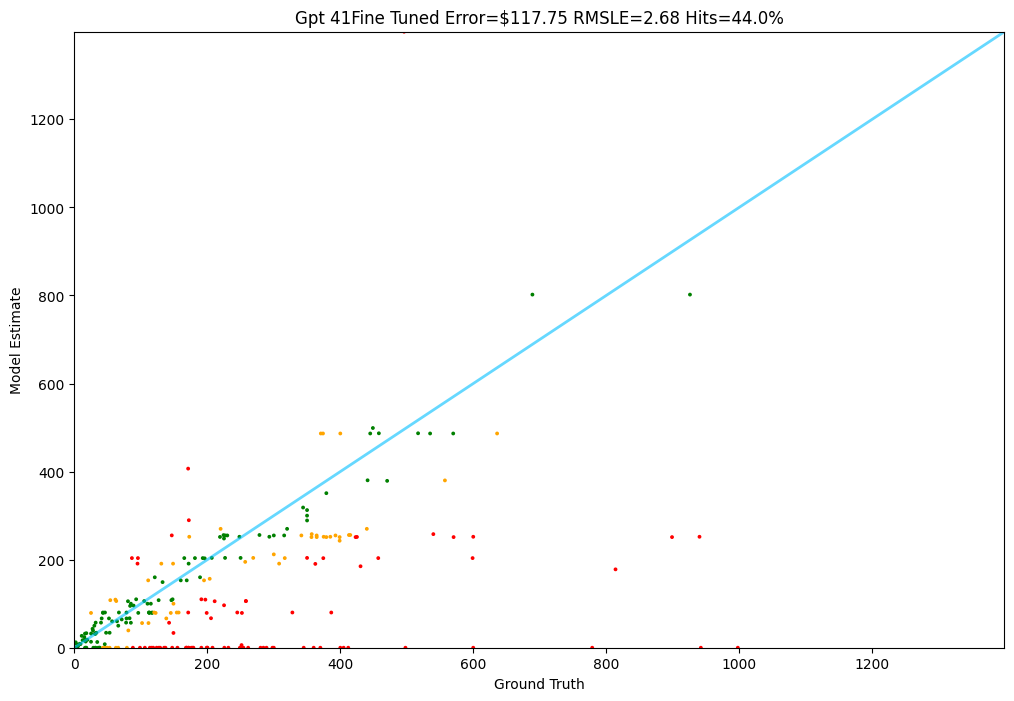

In [254]:
Tester.test(gpt_41fine_tuned, test)

###